In [22]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.model_selection import cross_val_score


plt.rcParams['font.sans-serif'] = "PingFang HK"

# 加载数据
df = pd.read_csv('housing.csv')

# 分离特征和目标
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 训练模型
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=5,
    cat_features=['ocean_proximity'],
    eval_metric='RMSE',         
    custom_metric=['MAE', 'R2'],
    random_seed=42,
    verbose=100,
)


model.fit(X_train, y_train, eval_set=(X_test, y_test))

# 预测和评估
y_pred = model.predict(X_test)
print(f"\nRMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}")
print(f"MAE:  ${mean_absolute_error(y_test, y_pred):,.2f}")
print(f"R²:   {r2_score(y_test, y_pred):.4f}")

0:	learn: 108890.7510788	test: 107931.5261406	best: 107931.5261406 (0)	total: 10.8ms	remaining: 10.8s
100:	learn: 47594.0920254	test: 51352.9370699	best: 51352.9370699 (100)	total: 459ms	remaining: 4.09s
200:	learn: 42272.6029227	test: 48326.7428228	best: 48326.7428228 (200)	total: 893ms	remaining: 3.55s
300:	learn: 39091.0914697	test: 47044.9235282	best: 47044.9235282 (300)	total: 1.32s	remaining: 3.06s
400:	learn: 36578.3781075	test: 46305.0433348	best: 46305.0433348 (400)	total: 1.76s	remaining: 2.62s
500:	learn: 34406.5519001	test: 45817.6312740	best: 45817.6312740 (500)	total: 2.23s	remaining: 2.22s
600:	learn: 32575.5109029	test: 45554.5290790	best: 45543.7963349 (596)	total: 2.67s	remaining: 1.77s
700:	learn: 31079.0159258	test: 45522.7909729	best: 45508.4791051 (680)	total: 3.12s	remaining: 1.33s
800:	learn: 29763.3063805	test: 45437.5156174	best: 45422.5064918 (793)	total: 3.58s	remaining: 889ms
900:	learn: 28504.0399625	test: 45639.5985094	best: 45422.5064918 (793)	total: 4.0

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.



95% 预测区间覆盖率: 94.21%


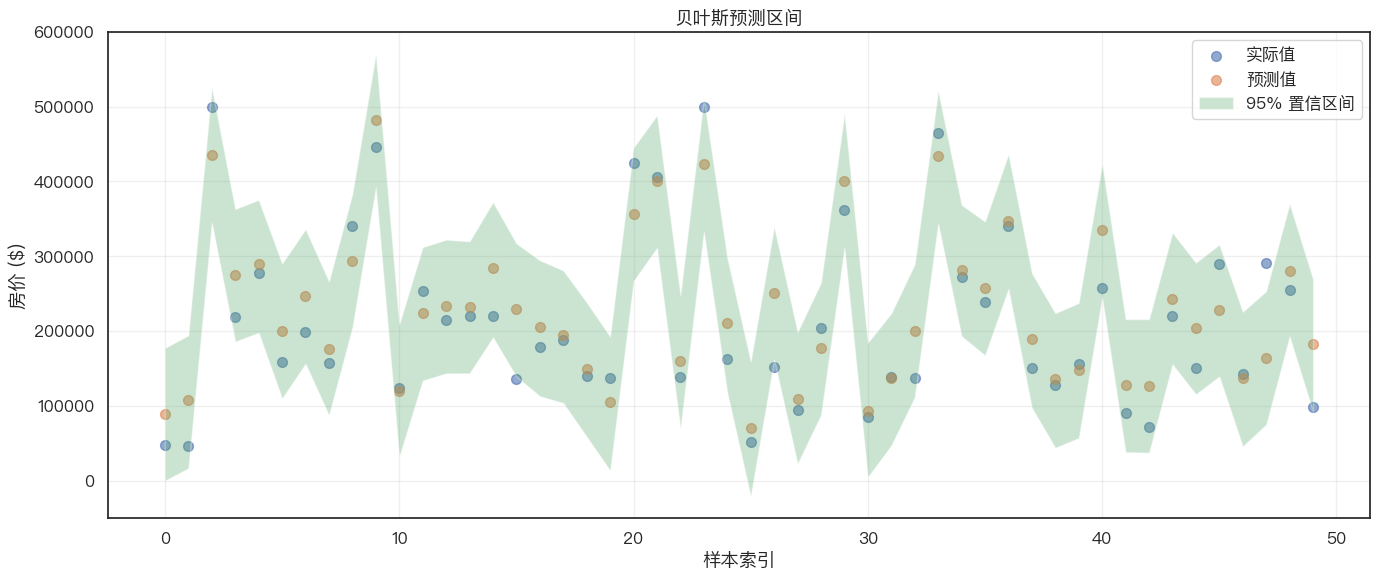

In [23]:
import pymc as pm
import arviz as az

def get_prediction_intervals(y_test, y_pred, confidence=0.95):
    """使用贝叶斯方法估计预测区间"""
    
    residuals = y_test.values - y_pred
    
    with pm.Model() as interval_model:
        # 建模参数
        mu = pm.Normal('mu', mu=0, sigma=50000)
        sigma = pm.HalfNormal('sigma', sigma=50000)
        
        # 观测误差
        pm.Normal('obs', mu=mu, sigma=sigma, observed=residuals)
        
        # 采样
        trace = pm.sample(1000, tune=500, return_inferencedata=True,
                         random_seed=42, progressbar=False)
    
    # 提取后验分布
    posterior_mu = trace.posterior['mu'].values.flatten()
    posterior_sigma = trace.posterior['sigma'].values.flatten()
    
    # 计算预测区间
    alpha = 1 - confidence
    lower_percentile = alpha / 2 * 100
    upper_percentile = (1 - alpha / 2) * 100
    
    # 为每个预测值生成区间
    lower_bounds = []
    upper_bounds = []
    
    for pred in y_pred:
        # 使用后验分布生成预测分布
        pred_dist = np.random.normal(
            pred + np.mean(posterior_mu), 
            np.mean(posterior_sigma), 
            size=10000
        )
        lower_bounds.append(np.percentile(pred_dist, lower_percentile))
        upper_bounds.append(np.percentile(pred_dist, upper_percentile))
    
    return np.array(lower_bounds), np.array(upper_bounds)

# 获取95%置信区间
lower, upper = get_prediction_intervals(y_test, y_pred)

# 计算覆盖率
coverage = np.mean((y_test.values >= lower) & (y_test.values <= upper))
print(f"\n95% 预测区间覆盖率: {coverage:.2%}")

# 可视化前50个预测
plt.figure(figsize=(14, 6))
indices = range(50)
plt.scatter(indices, y_test.values[:50], label='实际值', alpha=0.6, s=50)
plt.scatter(indices, y_pred[:50], label='预测值', alpha=0.6, s=50)
plt.fill_between(indices, lower[:50], upper[:50], alpha=0.3, label='95% 置信区间')
plt.xlabel('样本索引')
plt.ylabel('房价 ($)')
plt.title('贝叶斯预测区间')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_error, std_error, degrees_freedom]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


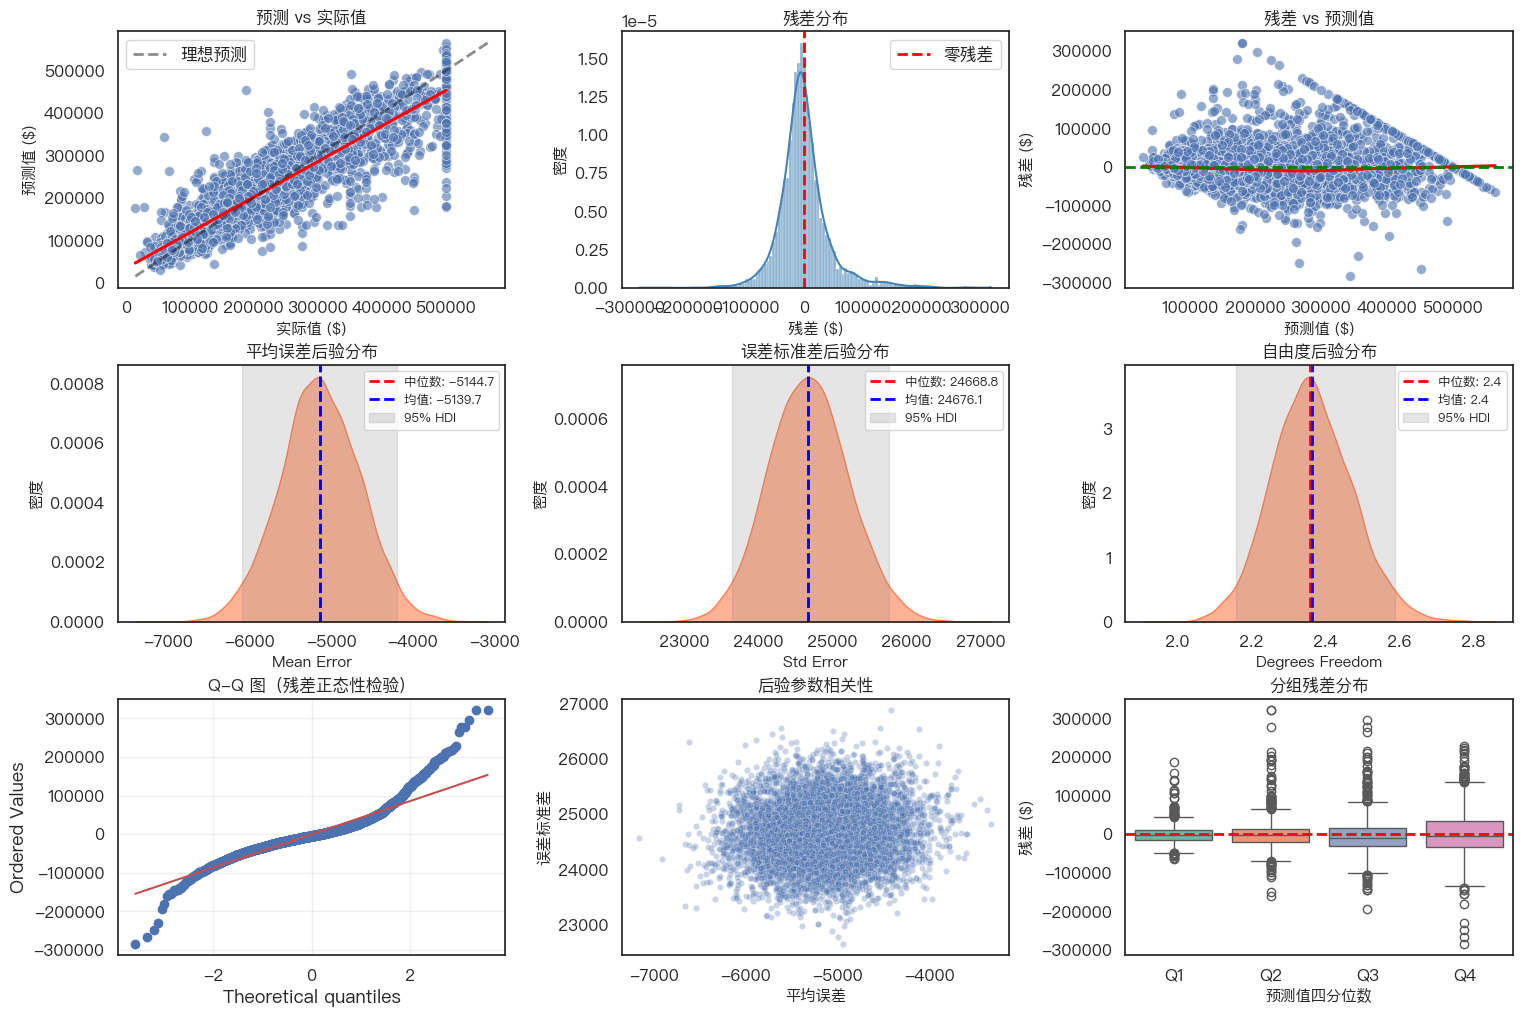


贝叶斯评估结果
                      mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
mean_error       -5139.736  487.273  -6071.873  -4241.225      6.021    5.125   
std_error        24676.053  539.530  23643.162  25668.548      7.707    5.405   
degrees_freedom      2.363    0.108      2.166      2.572      0.002    0.001   

                 ess_bulk  ess_tail  r_hat  
mean_error         6546.0    6173.0    1.0  
std_error          4901.0    5235.0    1.0  
degrees_freedom    4722.0    5302.0    1.0  


In [24]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd




def bayesian_evaluate_with_seaborn(y_true, y_pred):
    """使用 Seaborn 进行贝叶斯评估可视化"""
    
    residuals = y_true.values - y_pred
    
    # 构建贝叶斯模型
    with pm.Model() as eval_model:
        mu_error = pm.Normal('mean_error', mu=0, sigma=50000)
        sigma_error = pm.HalfNormal('std_error', sigma=50000)
        nu = pm.Gamma('degrees_freedom', alpha=2, beta=0.1)
        
        obs = pm.StudentT('residuals', mu=mu_error, sigma=sigma_error, 
                         nu=nu, observed=residuals)
        
        trace = pm.sample(2000, tune=1000, random_seed=42, 
                         return_inferencedata=True, progressbar=True)
    
    # 创建数据框便于 seaborn 绘图
    results_df = pd.DataFrame({
        'actual': y_true.values,
        'predicted': y_pred,
        'residuals': residuals
    })
    
    # 提取后验样本
    posterior_df = pd.DataFrame({
        'mean_error': trace.posterior['mean_error'].values.flatten(),
        'std_error': trace.posterior['std_error'].values.flatten(),
        'degrees_freedom': trace.posterior['degrees_freedom'].values.flatten()
    })
    
    # 创建综合可视化
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. 预测 vs 实际（使用 regplot）
    ax1 = fig.add_subplot(gs[0, 0])
    sns.scatterplot(data=results_df, x='actual', y='predicted', 
                   alpha=0.6, s=50, ax=ax1)
    sns.regplot(data=results_df, x='actual', y='predicted', 
                scatter=False, color='red', ax=ax1)
    # 添加理想线
    min_val = min(results_df['actual'].min(), results_df['predicted'].min())
    max_val = max(results_df['actual'].max(), results_df['predicted'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.5, label='理想预测')
    ax1.set_xlabel('实际值 ($)', fontsize=11)
    ax1.set_ylabel('预测值 ($)', fontsize=11)
    ax1.set_title('预测 vs 实际值', fontsize=12, fontweight='bold')
    ax1.legend()
    
    # 2. 残差分布（使用 histplot + kdeplot）
    ax2 = fig.add_subplot(gs[0, 1])
    sns.histplot(data=results_df, x='residuals', kde=True, 
                stat='density', alpha=0.6, ax=ax2, color='steelblue')
    ax2.axvline(x=0, color='red', linestyle='--', lw=2, label='零残差')
    ax2.set_xlabel('残差 ($)', fontsize=11)
    ax2.set_ylabel('密度', fontsize=11)
    ax2.set_title('残差分布', fontsize=12, fontweight='bold')
    ax2.legend()
    
    # 3. 残差 vs 预测值（检查异方差性）
    ax3 = fig.add_subplot(gs[0, 2])
    sns.scatterplot(data=results_df, x='predicted', y='residuals', 
                   alpha=0.6, s=50, ax=ax3)
    sns.regplot(data=results_df, x='predicted', y='residuals',
                scatter=False, color='red', lowess=True, ax=ax3)
    ax3.axhline(y=0, color='green', linestyle='--', lw=2)
    ax3.set_xlabel('预测值 ($)', fontsize=11)
    ax3.set_ylabel('残差 ($)', fontsize=11)
    ax3.set_title('残差 vs 预测值', fontsize=12, fontweight='bold')
    
    # 4-6. 后验分布（使用 kdeplot）
    params = ['mean_error', 'std_error', 'degrees_freedom']
    titles = ['平均误差后验分布', '误差标准差后验分布', '自由度后验分布']
    
    for i, (param, title) in enumerate(zip(params, titles)):
        ax = fig.add_subplot(gs[1, i])
        sns.kdeplot(data=posterior_df, x=param, fill=True, 
                   alpha=0.6, ax=ax, color='coral')
        
        # 添加统计线
        median = posterior_df[param].median()
        mean = posterior_df[param].mean()
        ax.axvline(median, color='red', linestyle='--', lw=2, label=f'中位数: {median:.1f}')
        ax.axvline(mean, color='blue', linestyle='--', lw=2, label=f'均值: {mean:.1f}')
        
        # 添加 95% HDI
        hdi_lower = posterior_df[param].quantile(0.025)
        hdi_upper = posterior_df[param].quantile(0.975)
        ax.axvspan(hdi_lower, hdi_upper, alpha=0.2, color='gray', label='95% HDI')
        
        ax.set_xlabel(param.replace('_', ' ').title(), fontsize=11)
        ax.set_ylabel('密度', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
    
    # 7. Q-Q 图（检查正态性）
    ax7 = fig.add_subplot(gs[2, 0])
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=ax7)
    ax7.set_title('Q-Q 图（残差正态性检验）', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3)
    
    # 8. 后验参数相关性
    ax8 = fig.add_subplot(gs[2, 1])
    sns.scatterplot(data=posterior_df, x='mean_error', y='std_error', 
                   alpha=0.3, s=20, ax=ax8)
    ax8.set_xlabel('平均误差', fontsize=11)
    ax8.set_ylabel('误差标准差', fontsize=11)
    ax8.set_title('后验参数相关性', fontsize=12, fontweight='bold')
    
    # 9. 箱线图（按预测值分组的残差）
    ax9 = fig.add_subplot(gs[2, 2])
    results_df['pred_quartile'] = pd.qcut(results_df['predicted'], 
                                           q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    sns.boxplot(data=results_df, x='pred_quartile', y='residuals', 
               palette='Set2', ax=ax9)
    ax9.axhline(y=0, color='red', linestyle='--', lw=2)
    ax9.set_xlabel('预测值四分位数', fontsize=11)
    ax9.set_ylabel('残差 ($)', fontsize=11)
    ax9.set_title('分组残差分布', fontsize=12, fontweight='bold')
    
    plt.savefig('bayesian_eval_seaborn.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印统计摘要
    print("\n" + "="*70)
    print("贝叶斯评估结果")
    print("="*70)
    print(az.summary(trace, var_names=['mean_error', 'std_error', 'degrees_freedom']))
    
    return trace, results_df, posterior_df

# 执行评估
trace, results_df, posterior_df = bayesian_evaluate_with_seaborn(y_test, y_pred)

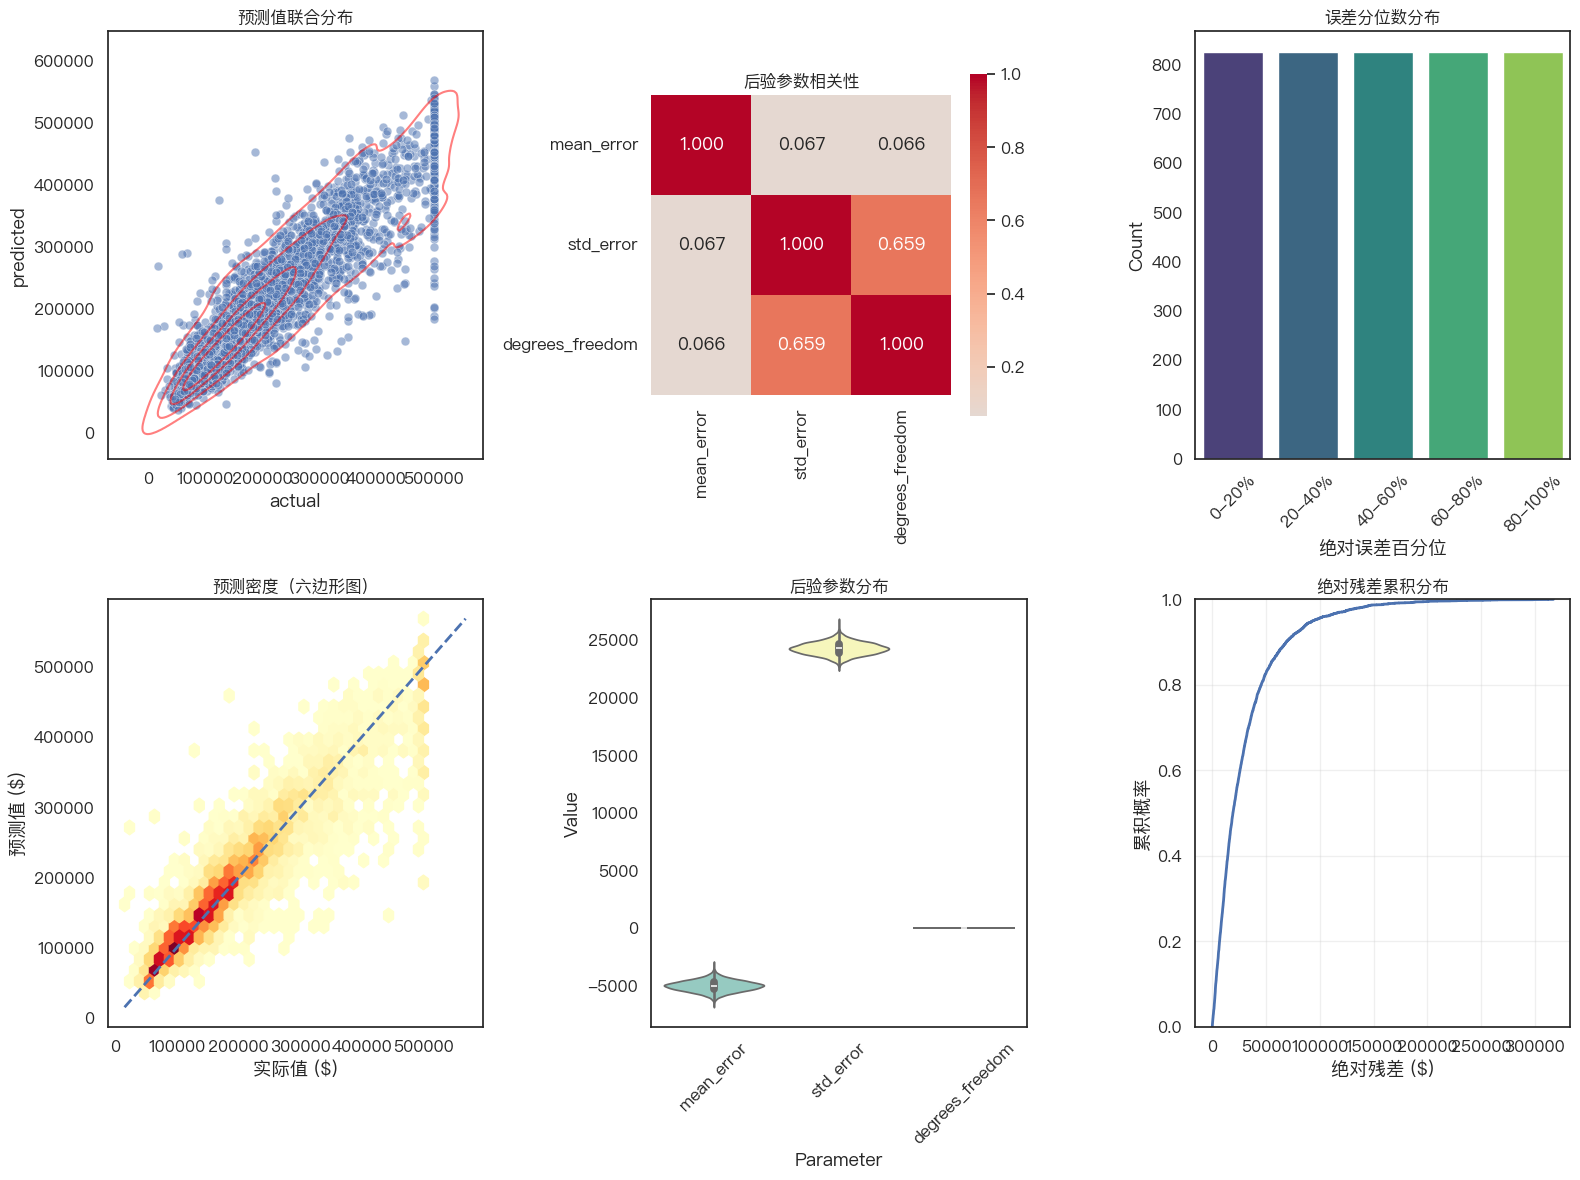

In [20]:
plt.rcParams['font.sans-serif'] = "PingFang HK"


def advanced_seaborn_visualization(y_true, y_pred, posterior_df):
    """高级 Seaborn 可视化"""
    
    # 创建数据框
    results_df = pd.DataFrame({
        'actual': y_true.values,
        'predicted': y_pred,
        'residuals': y_true.values - y_pred,
        'abs_residuals': np.abs(y_true.values - y_pred)
    })
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. 联合分布图（JointPlot 风格）
    ax1 = plt.subplot(2, 3, 1)
    g = sns.scatterplot(data=results_df, x='actual', y='predicted', 
                       alpha=0.5, s=40, ax=ax1)
    sns.kdeplot(data=results_df, x='actual', y='predicted', 
               levels=5, color='red', alpha=0.5, ax=ax1)
    ax1.set_title('预测值联合分布', fontweight='bold', fontsize=12)
    
    # 2. 后验参数相关性热图
    ax2 = plt.subplot(2, 3, 2)
    corr_matrix = posterior_df.corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
               center=0, square=True, ax=ax2, cbar_kws={'shrink': 0.8})
    ax2.set_title('后验参数相关性', fontweight='bold', fontsize=12)
    
    # 3. 误差分位数图
    ax3 = plt.subplot(2, 3, 3)
    results_df['error_percentile'] = pd.qcut(results_df['abs_residuals'], 
                                             q=5, labels=['0-20%', '20-40%', 
                                                         '40-60%', '60-80%', '80-100%'])
    count_df = results_df['error_percentile'].value_counts().reset_index()
    count_df.columns = ['Percentile', 'Count']
    sns.barplot(data=count_df, x='Percentile', y='Count', 
               palette='viridis', ax=ax3)
    ax3.set_title('误差分位数分布', fontweight='bold', fontsize=12)
    ax3.set_xlabel('绝对误差百分位')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. 六边形密度图
    ax4 = plt.subplot(2, 3, 4)
    ax4.hexbin(results_df['actual'], results_df['predicted'], 
              gridsize=30, cmap='YlOrRd', mincnt=1)
    min_val = min(results_df['actual'].min(), results_df['predicted'].min())
    max_val = max(results_df['actual'].max(), results_df['predicted'].max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'b--', lw=2)
    ax4.set_xlabel('实际值 ($)')
    ax4.set_ylabel('预测值 ($)')
    ax4.set_title('预测密度（六边形图）', fontweight='bold', fontsize=12)
    
    # 5. 后验分布对比（Ridge plot 风格）
    ax5 = plt.subplot(2, 3, 5)
    posterior_long = pd.melt(posterior_df, var_name='Parameter', value_name='Value')
    sns.violinplot(data=posterior_long, x='Parameter', y='Value', 
                  palette='Set3', ax=ax5)
    ax5.set_title('后验参数分布', fontweight='bold', fontsize=12)
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. 累积分布函数
    ax6 = plt.subplot(2, 3, 6)
    sns.ecdfplot(data=results_df, x='abs_residuals', ax=ax6, lw=2)
    ax6.set_xlabel('绝对残差 ($)')
    ax6.set_ylabel('累积概率')
    ax6.set_title('绝对残差累积分布', fontweight='bold', fontsize=12)
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 使用示例
advanced_seaborn_visualization(y_test, y_pred, posterior_df)